In [1]:
# data stuff:
import pandas as pd
import numpy as np

# modeling stuff:
from prophet import Prophet
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# optimization stuff:
import optuna

# plotting stuff:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image

# silence!
import warnings
warnings.filterwarnings("ignore")

---
## Meta's PROPHET Forecasting Model:
See documentation here:

https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html

---

### Import Data:

**Note:** because Prophet can only handle univariate forecasting, we sum the visitor count across all restaurants and use that figure as our target for the forecast.

In [2]:
# read data, aggregate on visit date:
y = pd.read_csv('data/air_visit_data.csv')
y = y.pivot(index='visit_date', columns='air_store_id')['visitors']
y = y.fillna(0)
y = pd.DataFrame(y.sum(axis=1))

# prepare data for the Prophet model, which requires the date column to be named 'ds'
# and the target col to be named 'y':
y = y.reset_index(drop=False)
y.columns = ['ds', 'y']

In [3]:
y

ds        y
0    2016-01-01   1033.0
1    2016-01-02   1764.0
2    2016-01-03   2368.0
3    2016-01-04   3326.0
4    2016-01-05   3927.0
..          ...      ...
473  2017-04-18  13489.0
474  2017-04-19  14607.0
475  2017-04-20  13990.0
476  2017-04-21  19624.0
477  2017-04-22  21245.0

[478 rows x 2 columns]

### Plot:

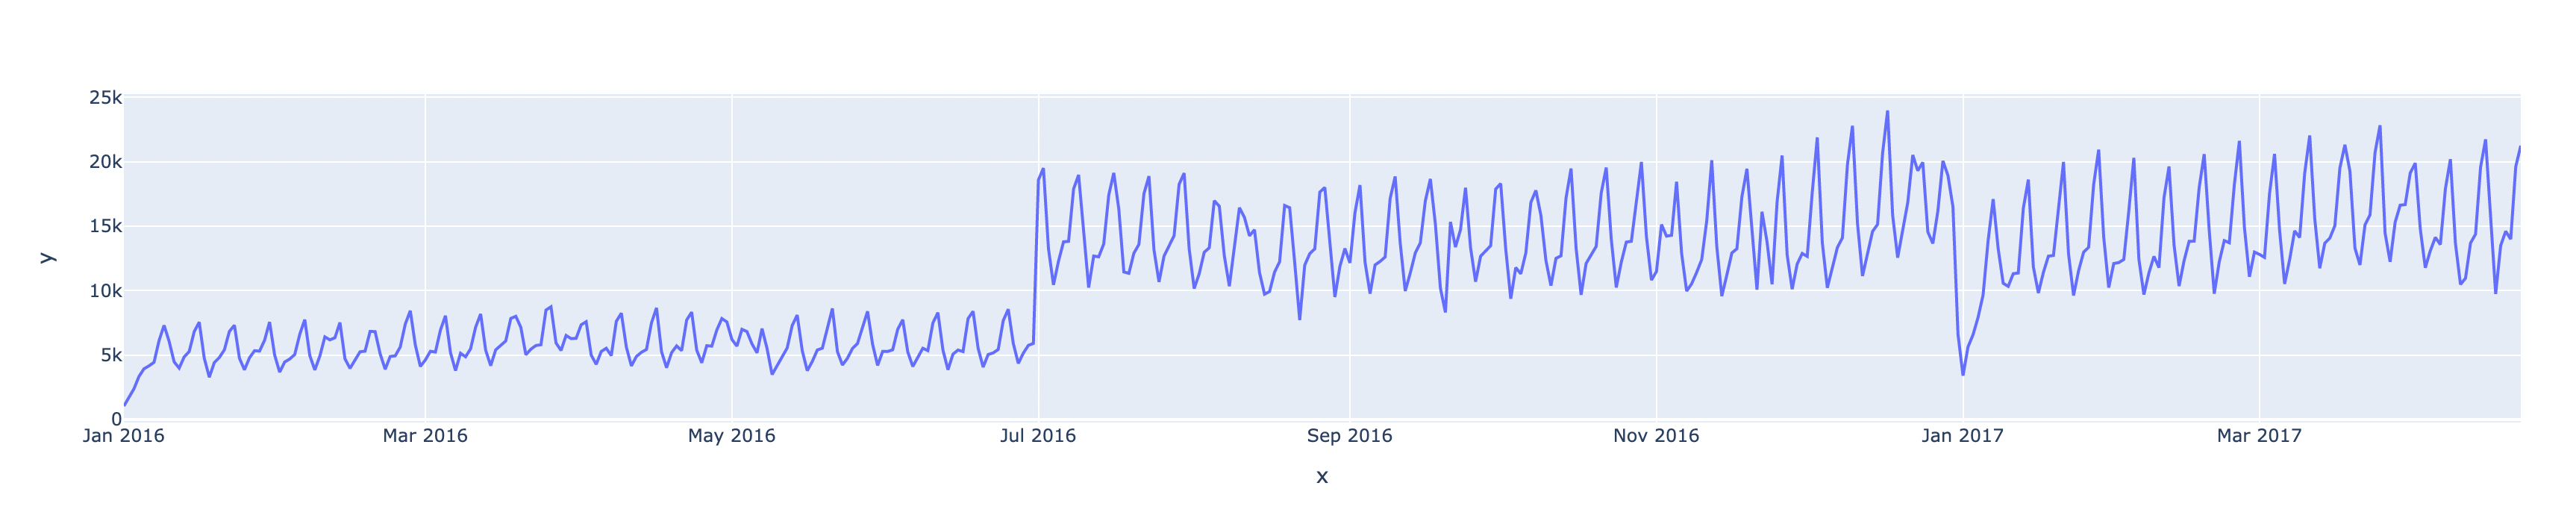

In [34]:
px.line(x=y['ds'], y=y['y'])
Image(filename='./images/ch19_raw.png', width=1800)

---
### Fit a basic PROPHET model:
Below we fit a simple model without any seasonal nor external influences.

#### Split into train/test:

In [5]:
# we take the first 450 days as training, and the remaining 28 as test:
train = y.iloc[:450,:]
test = y.iloc[450:,:]

#### Initialize and fit model:

In [6]:
m = Prophet()
m.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93       812.583     0.0101763       177.011    0.000139       0.001      164  LS failed, Hessian reset 
      99       812.812    0.00391398         74.28           1           1      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134        813.05   0.000248612       63.3672    3.67e-06       0.001      259  LS failed, Hessian reset 
     174       813.076   9.71975e-05        74.314   1.227e-06       0.001      354  LS failed, Hessian reset 
     199       813.082   1.01931e-06       71.9617       0.926       0.926      389   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       813.082   7.64401e-08       60.7171           1           1      406   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

#### Forecast:

In [7]:
# define number of steps to forecast:
pred_steps = len(test)

# define "future" dataframe to hold the forecasted values:
future = m.make_future_dataframe(periods=pred_steps)

# forecast:
forecast = m.predict(future)
forecast.head()

ds        trend   yhat_lower    yhat_upper  trend_lower  \
0 2016-01-01  4206.704611  3957.031087   9420.536948  4206.704611   
1 2016-01-02  4227.672820  5204.506196  10715.844772  4227.672820   
2 2016-01-03  4248.641030   871.152157   6382.026925  4248.641030   
3 2016-01-04  4269.609240 -1465.409954   3973.145475  4269.609240   
4 2016-01-05  4290.577449  -113.093480   5403.937148  4290.577449   

   trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  4206.704611     2397.864095           2397.864095           2397.864095   
1  4227.672820     3835.886083           3835.886083           3835.886083   
2  4248.641030     -455.908818           -455.908818           -455.908818   
3  4269.609240    -2943.123974          -2943.123974          -2943.123974   
4  4290.577449    -1659.883807          -1659.883807          -1659.883807   

        weekly  weekly_lower  weekly_upper  multiplicative_terms  \
0  2397.864095   2397.864095   2397.864095                   0.0   
1  3835.886083   3835.886083   3835.886083                   0.0   
2  -455.908818   -455.908818   -455.908818                   0.0   
3 -2943.123974  -2943.123974  -2943.123974                   0.0   
4 -1659.883807  -1659.883807  -1659.883807                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper         yhat  
0                         0.0                         0.0  6604.568706  
1                         0.0                         0.0  8063.558903  
2                         0.0                         0.0  3792.732212  
3                         0.0                         0.0  1326.485266  
4                         0.0                         0.0  2630.693642

**Note:** the forecast dataframe above includes the train set as well as the test set in the output. So be sure to grab the test forecast by indexing properly.

#### Evaluate and plot:

In [36]:
simple_score = np.round(r2_score(list(test['y']), list(forecast.loc[450:,'yhat'])), 2)
simple_score

0.81

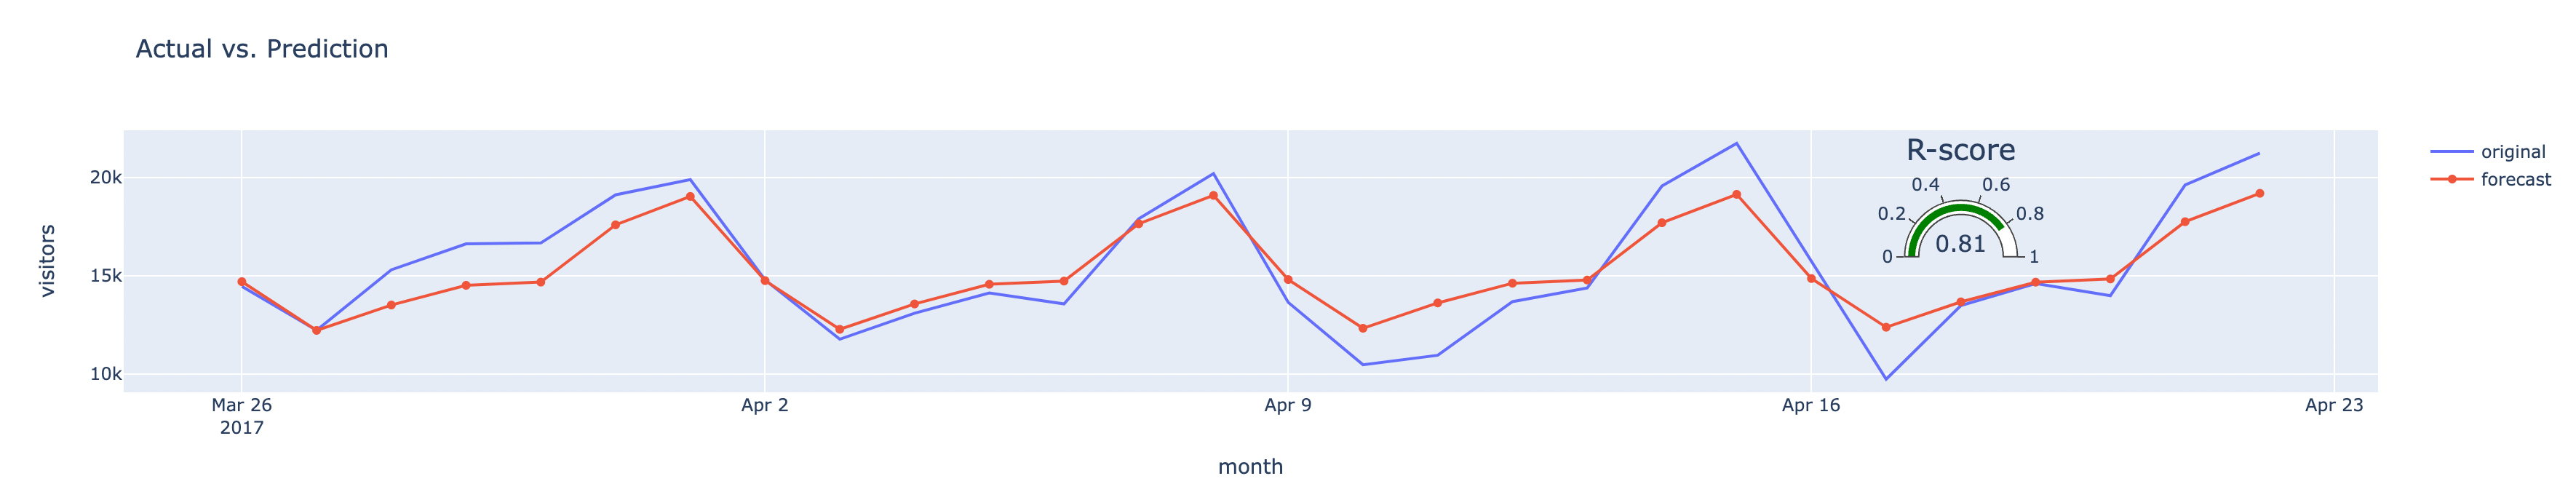

In [37]:
fig = go.Figure()

# actual:
fig.add_trace(go.Scatter(x=test['ds'], y=test['y'], mode='lines', name='original'))
# predicted:
fig.add_trace(go.Scatter(x=test['ds'], y=forecast.loc[450:,'yhat'], mode='lines+markers', name='forecast'))
# r-score:
fig.add_trace(go.Indicator(
    mode = "gauge+number",
    value = simple_score,
    title = {'text': "R-score"},
    domain = {'x': [0.79, 0.84], 'y': [0.5, 0.75]},
    gauge = {'axis': {'range': [0, 1]}},
))

fig.update_layout(
    title="Actual vs. Prediction",
    xaxis_title="month",
    yaxis_title="visitors")
Image(filename='./images/ch19_simple.png', width=1800)

#### Display the PROPHET forecast plot:
Below we can see the observed values (black dots) as well as the forecasted values (blue line).

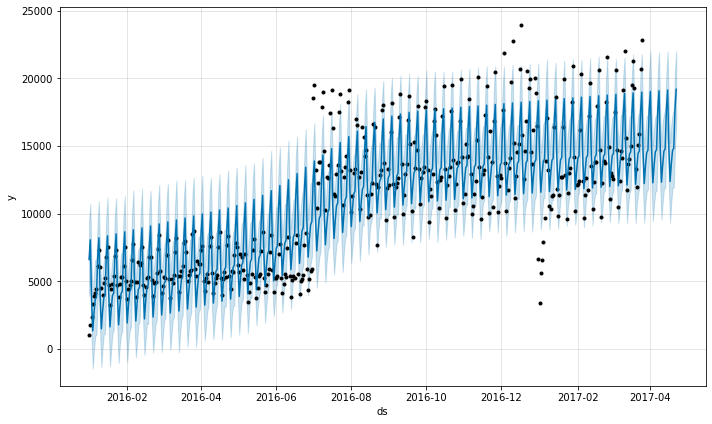

In [10]:
m.plot(forecast);

#### Display the PROPHET Decomposition plot:
The plots below show us the decomposed trend in terms of their granular elements (weekly) and their longer-term elements such as the yearly trends.

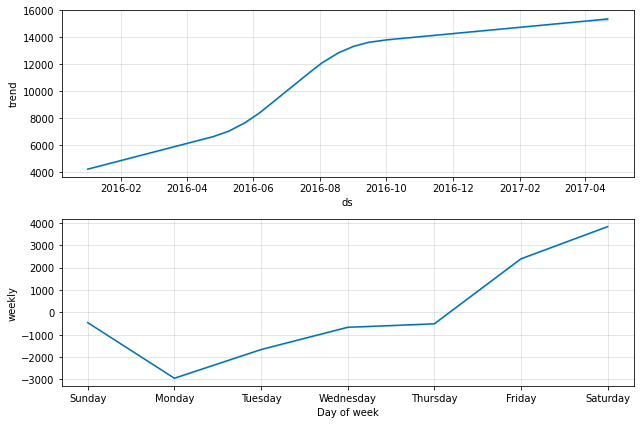

In [11]:
 m.plot_components(forecast);

&nbsp;

---
### Fit a PROPHET model using a seasonality term:

Please see here for a description of how Fourier series are used to model seasonality:

* https://en.wikipedia.org/wiki/Fourier_series#
* https://peerj.com/preprints/3190/

In [12]:
# initialize the second model:
m2 = Prophet()

# add seasonality term and fit:
m2.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m2.fit(train)

# forecast:
pred_steps = len(test)
future2 = m2.make_future_dataframe(periods=pred_steps)
forecast2 = m2.predict(future)

# r-score:
seasonal_score = np.round(r2_score(list(test['y']), list(forecast2.loc[450:,'yhat'])), 2)
seasonal_score

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       819.008   4.28174e-05       60.1845      0.7944      0.7944      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       819.406   0.000112387       46.2908   1.835e-06       0.001      252  LS failed, Hessian reset 
     199       819.736   0.000434864       71.6952      0.2636      0.7165      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       819.749   1.54002e-08       62.1759     0.05729           1      362   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


0.79

#### Plot components:
**Note:** please observe that since we added the monthly seasonal trend, we get an additional plot showing the corresponding decomposition.

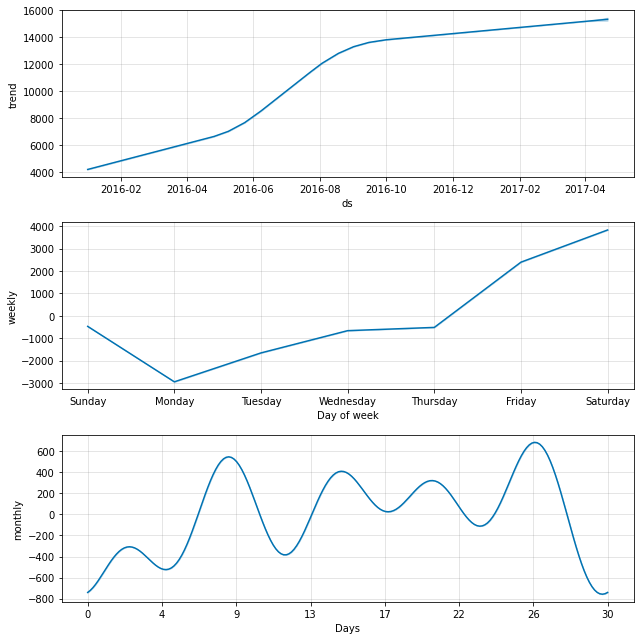

In [13]:
m2.plot_components(forecast2);

&nbsp;

---
### PROPHET model with an extra regressor:
Below, we add the number of restaurant reservations to the model as an external regressor.

In [14]:
# read the reservations file:
X_reservations = pd.read_csv('data/air_reserve.csv')
X_reservations['visit_date'] = pd.to_datetime(X_reservations['visit_datetime']).dt.date

# aggreate the reservations across all restaurants:
X_reservations = pd.DataFrame(X_reservations.groupby('visit_date')['reserve_visitors'].sum())
X_reservations = X_reservations.reset_index(drop = False)

# create a new train file merging the reservations to the original visitor counts:
train_x = train.copy()
train_x['ds'] = pd.to_datetime(train_x['ds']).dt.date
train_x = train_x.merge(X_reservations, left_on = 'ds', right_on = 'visit_date', how = 'left')[['ds', 'y', 'reserve_visitors']].fillna(0)

In [15]:
train_x

ds        y  reserve_visitors
0    2016-01-01   1033.0              17.0
1    2016-01-02   1764.0             128.0
2    2016-01-03   2368.0              53.0
3    2016-01-04   3326.0             122.0
4    2016-01-05   3927.0              76.0
..          ...      ...               ...
445  2017-03-21  11987.0            1357.0
446  2017-03-22  15101.0            2071.0
447  2017-03-23  15879.0            1789.0
448  2017-03-24  20720.0            3866.0
449  2017-03-25  22836.0            3233.0

[450 rows x 3 columns]

#### Plot visitors and reservations:

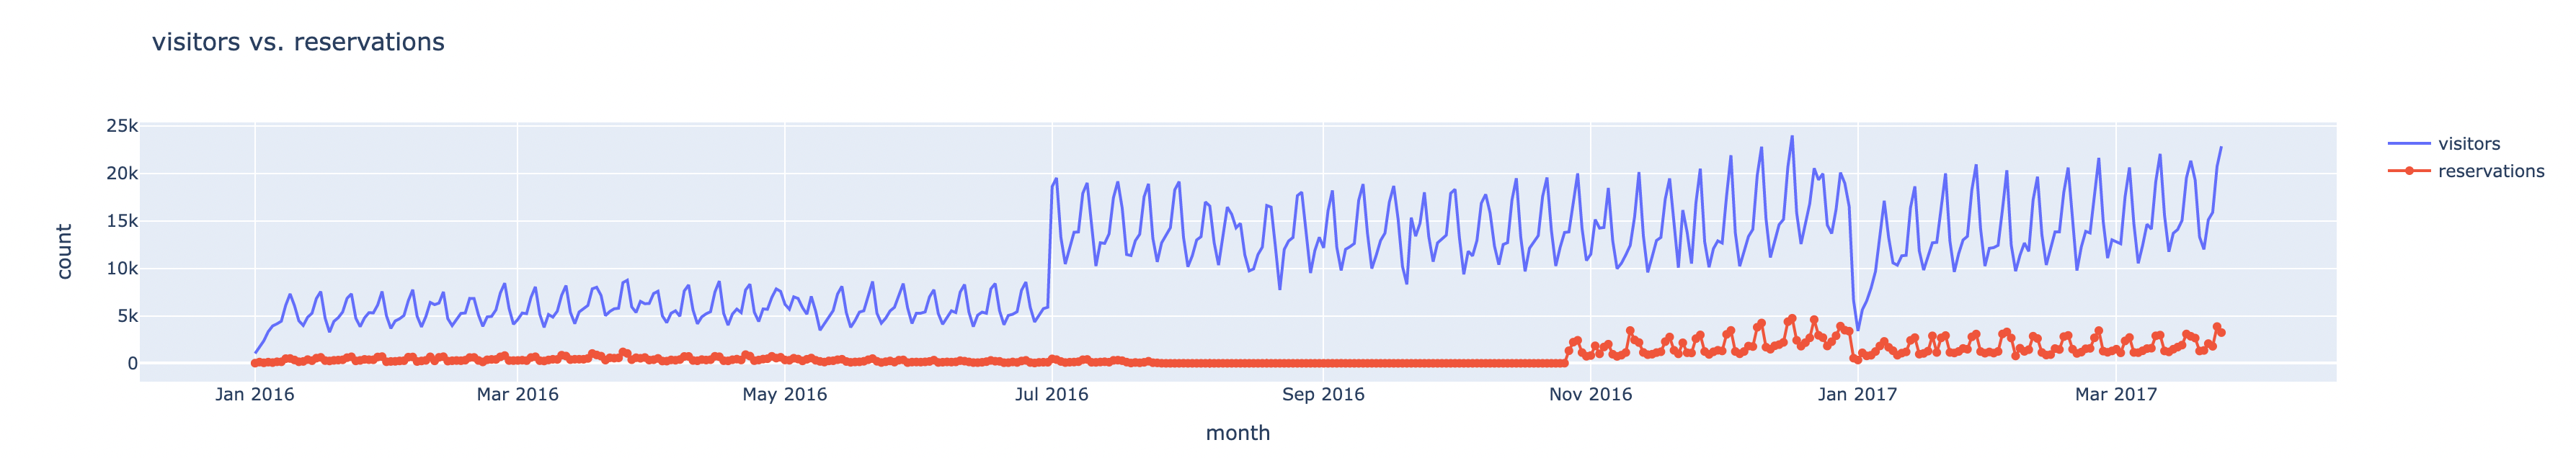

In [38]:
fig = go.Figure()

# visitors:
fig.add_trace(go.Scatter(x=train_x['ds'], y=train_x['y'], mode='lines', name='visitors'))
# reservations:
fig.add_trace(go.Scatter(x=train_x['ds'], y=train_x['reserve_visitors'], mode='lines+markers', name='reservations'))


fig.update_layout(
    title="visitors vs. reservations",
    xaxis_title="month",
    yaxis_title="count")
Image(filename='./images/ch19_reserve.png', width=1800)

#### Add reservations to the model:

In [17]:
# initialize, add external regressor, and fit:
mx = Prophet()
# mx.add_seasonality(name='monthly', period=30.5, fourier_order=5)
mx.add_regressor('reserve_visitors')
mx.fit(train_x)

# define forecast df:
pred_steps = len(test)
futurex = mx.make_future_dataframe(periods=pred_steps)
futurex['ds'] = pd.to_datetime(futurex['ds']).dt.date

# add date and reservations to the forecast df:
futurex = futurex.merge(X_reservations, left_on = 'ds', right_on = 'visit_date', how = 'left')[['ds', 'reserve_visitors']].fillna(0)

# forecast:
forecastx = mx.predict(futurex)

# score
x_score = np.round(r2_score(list(test['y']), list(forecastx.loc[450:,'yhat'])), 2)
x_score

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       847.508    0.00640975       91.1601           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       847.611   0.000587731       85.2016   5.904e-06       0.001      157  LS failed, Hessian reset 
     199       850.433   0.000459538       75.2402      0.2915      0.7517      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     218       850.855     0.0023929       119.201   2.562e-05       0.001      350  LS failed, Hessian reset 
     240       851.088   0.000364373       73.5501   4.701e-06       0.001      414  LS failed, Hessian reset 
     299       851.137   0.000251419       71.4391           1           1      497   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

0.85

#### Plot components:

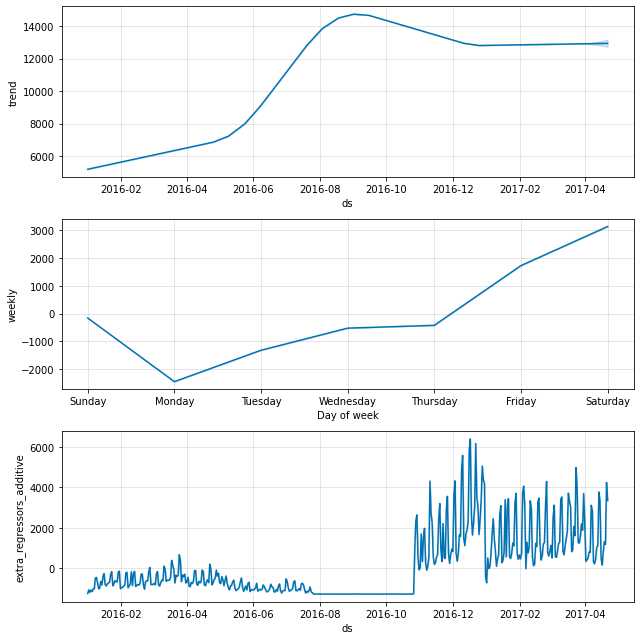

In [18]:
mx.plot_components(forecastx);

&nbsp;

---
### Bayesian Hyperparameter tuning for Prophet using Optuna:

##### Prepare holidays data:

In [19]:
# get holiday info from file:
holidays = pd.read_csv('data/date_info.csv')
holidays = holidays[holidays['holiday_flg'] == 1]
holidays = holidays[['calendar_date', 'holiday_flg']]
holidays = holidays.drop(['holiday_flg'], axis=1)
holidays['holiday'] = 'holiday'
holidays.columns = ['ds', 'holiday']
holidays.head()

ds  holiday
0   2016-01-01  holiday
1   2016-01-02  holiday
2   2016-01-03  holiday
10  2016-01-11  holiday
41  2016-02-11  holiday

In [20]:
def objective_prophet(trial):
    # train set:
    train_opt = train.copy()
    train_opt['ds'] = pd.to_datetime(train_opt['ds']).dt.date
    
    # prophet params:
    holidays_opt = trial.suggest_categorical('holidays_opt', [True, False])
    weekly_seasonality = trial.suggest_int('weekly_seasonality', 5, 50, step=5)
    yearly_seasonality = trial.suggest_int('yearly_seasonality', 5, 50, step=5)
    add_monthly = trial.suggest_categorical('add_monthly', [True, False])
    add_reserve = trial.suggest_categorical('add_reserve', [True, False])
    changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', 0.1, 5, step=0.05)
    holidays_prior_scale = trial.suggest_float('holidays_prior_scale', 0.1, 5, step=0.05)
    month_fourier = trial.suggest_int('month_fourier', 5, 50, step=5)
    
    # initialize model:
    if holidays_opt:
        model = Prophet(yearly_seasonality=yearly_seasonality, 
                        weekly_seasonality=weekly_seasonality, 
                        holidays=holidays, 
                        changepoint_prior_scale=changepoint_prior_scale, 
                        holidays_prior_scale=holidays_prior_scale)
    else:
        model = Prophet(yearly_seasonality=yearly_seasonality, 
                        weekly_seasonality=weekly_seasonality, 
                        changepoint_prior_scale=changepoint_prior_scale, 
                        holidays_prior_scale=holidays_prior_scale)
    
    # handle seasonality:
    if add_monthly:
        model.add_seasonality(name='monthly', 
                              period=30.5, 
                              fourier_order=month_fourier)
    
    # handle external regressor (add to model):
    if add_reserve:
        train_opt = train_opt.merge(X_reservations, 
                                    left_on = 'ds', 
                                    right_on = 'visit_date', 
                                    how = 'left')[['ds', 'y', 'reserve_visitors']].fillna(0)
        model.add_regressor('reserve_visitors')
        
    # fit:
    model.fit(train_opt)
    
    # define number of steps to forecast:
    pred_steps = len(test)
    
    # handle external regressor (add to forecast df):
    if add_reserve:
        future = model.make_future_dataframe(periods=pred_steps)
        future['ds'] = pd.to_datetime(future['ds']).dt.date
        future = future.merge(X_reservations,
                              left_on = 'ds', 
                              right_on = 'visit_date', 
                              how = 'left')
        future = future[['ds', 'reserve_visitors']]
        future = future.fillna(0)
    else:
        # define "future" dataframe to hold the forecasted values:
        future = model.make_future_dataframe(periods=pred_steps)
        future['ds'] = pd.to_datetime(future['ds']).dt.date

    # forecast:
    forecast = model.predict(future)

    # obtain residuals and evaluate using r-squared:
    score = np.round(r2_score(list(test['y']), list(forecast.loc[450:,'yhat'])), 2)

    return score

In [21]:
# find optimal params (orders) that will maximize R-squared value:
study_prophet=optuna.create_study(direction="maximize")
study_prophet.optimize(objective_prophet, n_trials=50)

[I 2022-06-11 13:14:15,842] A new study created in memory with name: no-name-0139c0c4-285b-4431-a45e-2185d76ffe70
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1051.77    0.00134769       18.2125      0.7846      0.7846      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1052.2   0.000314168       16.1873      0.2939      0.2939      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1052.35    0.00137003       31.2356           1           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1052.48   0.000201532       6.04851      0.6142      0.6142      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     467       1052.52   0.000291208       29.6243   1.327e-05       0.001      581  LS failed, Hessian reset 
     499       1052.54   0.000108499    

[I 2022-06-11 13:14:17,350] Trial 0 finished with value: 0.67 and parameters: {'holidays_opt': True, 'weekly_seasonality': 20, 'yearly_seasonality': 25, 'add_monthly': True, 'add_reserve': False, 'changepoint_prior_scale': 0.75, 'holidays_prior_scale': 1.35, 'month_fourier': 20}. Best is trial 0 with value: 0.67.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1147.71   0.000106392       11.2552      0.8726      0.8726      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1148.26    0.00279337       29.0276           1           1      215   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1148.44    0.00206511       27.1021           1           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1148.59    0.00037314       16.8287           1           1      434   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     454       1148.64   4.63563e-05       5.76024   7.987e-06       0.001      525  LS failed, Hessian reset 
     499       1148.66   2.48578e-05    

[I 2022-06-11 13:14:18,677] Trial 1 finished with value: 0.85 and parameters: {'holidays_opt': False, 'weekly_seasonality': 25, 'yearly_seasonality': 30, 'add_monthly': False, 'add_reserve': True, 'changepoint_prior_scale': 2.3000000000000003, 'holidays_prior_scale': 0.5, 'month_fourier': 20}. Best is trial 1 with value: 0.85.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1089.56    0.00401832       63.7451       0.833       0.833      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1091.77    0.00620272       91.9467           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       1092.36   0.000215965       50.5402   2.446e-06       0.001      294  LS failed, Hessian reset 
     269       1092.65   0.000181686       7.25627   1.519e-05       0.001      383  LS failed, Hessian reset 
     273       1092.65   2.81938e-05       12.7797   4.906e-06       0.001      429  LS failed, Hessian reset 
     275       1092.65   1.43961e-05       9.94789   1.149e-06       0.001      467  LS failed, Hessian reset 
     278       1092.65   2.16215e-06       5.88511   2.175e-07   

[I 2022-06-11 13:14:19,814] Trial 2 finished with value: 0.57 and parameters: {'holidays_opt': True, 'weekly_seasonality': 5, 'yearly_seasonality': 50, 'add_monthly': False, 'add_reserve': False, 'changepoint_prior_scale': 0.15000000000000002, 'holidays_prior_scale': 1.4000000000000001, 'month_fourier': 35}. Best is trial 1 with value: 0.85.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1033.3    0.00619373       37.2162           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.77   0.000150641       27.2116      0.6274      0.6274      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     250       1033.94   8.31266e-05       8.79091   7.438e-06       0.001      328  LS failed, Hessian reset 
     299       1034.03   5.70948e-05       19.7147     0.02563     0.02563      383   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1034.27   0.000166065       9.04713      0.9227      0.9227      504   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1034.56    0.00014897    

[I 2022-06-11 13:14:20,941] Trial 3 finished with value: 0.8 and parameters: {'holidays_opt': False, 'weekly_seasonality': 10, 'yearly_seasonality': 5, 'add_monthly': True, 'add_reserve': True, 'changepoint_prior_scale': 0.55, 'holidays_prior_scale': 4.95, 'month_fourier': 5}. Best is trial 1 with value: 0.85.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1023.91   0.000196205       17.3564           1           1      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       1024.08   6.02316e-05       13.1966   6.654e-06       0.001      226  LS failed, Hessian reset 
     199        1024.1   0.000639816       5.81013           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1024.11    0.00355582       11.5914           1           1      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     348       1024.15    6.2257e-05       11.8028   8.301e-06       0.001      468  LS failed, Hessian reset 
     369       1024.16   9.29737e-06       4.05487   2.189e-06       0.001      528  LS failed, Hessian rese

[I 2022-06-11 13:14:22,624] Trial 4 finished with value: 0.62 and parameters: {'holidays_opt': False, 'weekly_seasonality': 35, 'yearly_seasonality': 15, 'add_monthly': True, 'add_reserve': False, 'changepoint_prior_scale': 1.35, 'holidays_prior_scale': 4.75, 'month_fourier': 50}. Best is trial 1 with value: 0.85.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1106.74    0.00388534       118.209      0.9183      0.9183      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1107.65     0.0127989       62.4566           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1107.74   0.000260256       7.88866      0.2721           1      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1107.76   0.000751126       7.89466      0.4536           1      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1107.77   3.13351e-05       2.61471      0.7609      0.7609      548   
    Iter      log prob        ||dx||      ||grad||       alpha  

[I 2022-06-11 13:14:24,162] Trial 5 finished with value: 0.33 and parameters: {'holidays_opt': True, 'weekly_seasonality': 15, 'yearly_seasonality': 45, 'add_monthly': True, 'add_reserve': False, 'changepoint_prior_scale': 2.85, 'holidays_prior_scale': 2.3000000000000003, 'month_fourier': 50}. Best is trial 1 with value: 0.85.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1053.05    0.00297989       29.2783           1           1      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1057.62     0.0147119       105.887           1           1      215   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1065.57    0.00789812       39.3667           1           1      318   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399          1069    0.00712028        34.451           1           1      424   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1071.33     0.0744568       369.388           1           1      529   
    Iter      log prob        ||dx||      ||grad||       alpha  

[I 2022-06-11 13:14:27,831] Trial 6 finished with value: 0.9 and parameters: {'holidays_opt': False, 'weekly_seasonality': 25, 'yearly_seasonality': 5, 'add_monthly': True, 'add_reserve': True, 'changepoint_prior_scale': 2.1500000000000004, 'holidays_prior_scale': 2.1500000000000004, 'month_fourier': 35}. Best is trial 6 with value: 0.9.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1180.32    0.00419897         145.2       0.472           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1180.71   0.000475693       24.0191      0.3484           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1180.83    0.00299587          20.2           1           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1180.99   0.000734376       17.4734           1           1      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1181.09    0.00185342       20.2328           1           1      566   
    Iter      log prob        ||dx||      ||grad||       alpha  

[I 2022-06-11 13:14:30,025] Trial 7 finished with value: 0.82 and parameters: {'holidays_opt': True, 'weekly_seasonality': 5, 'yearly_seasonality': 35, 'add_monthly': True, 'add_reserve': True, 'changepoint_prior_scale': 1.6, 'holidays_prior_scale': 4.45, 'month_fourier': 50}. Best is trial 6 with value: 0.9.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.32    0.00511157       58.6473           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1048.26    0.00296729       22.8745      0.4391      0.4391      215   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1048.8     0.0014718        19.793      0.5324      0.5324      319   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1049.11    0.00383966       21.2643           1           1      425   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1049.92    0.00961147       81.8309      0.6716      0.6716      530   
    Iter      log prob        ||dx||      ||grad||       alpha  

[I 2022-06-11 13:14:32,492] Trial 8 finished with value: 0.76 and parameters: {'holidays_opt': False, 'weekly_seasonality': 25, 'yearly_seasonality': 5, 'add_monthly': False, 'add_reserve': True, 'changepoint_prior_scale': 3.1, 'holidays_prior_scale': 1.7500000000000002, 'month_fourier': 15}. Best is trial 6 with value: 0.9.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1148.05   0.000113142       26.0158           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1148.6      0.000627       9.97895           1           1      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1148.66     0.0196506        80.492           1           1      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1148.71    0.00087025       28.8379           1           1      431   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1148.74    0.00037184       16.4438           1           1      538   
    Iter      log prob        ||dx||      ||grad||       alpha  

[I 2022-06-11 13:14:34,245] Trial 9 finished with value: 0.86 and parameters: {'holidays_opt': True, 'weekly_seasonality': 35, 'yearly_seasonality': 30, 'add_monthly': False, 'add_reserve': True, 'changepoint_prior_scale': 3.6500000000000004, 'holidays_prior_scale': 4.7, 'month_fourier': 20}. Best is trial 6 with value: 0.9.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1116.36    0.00370015       154.534           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1117.13   0.000170752       15.2155      0.9223      0.9223      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1117.3   0.000288316       13.0577           1           1      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1117.33   0.000456418        5.4469           1           1      428   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1117.45   0.000360535       27.1141      0.9257      0.9257      532   
    Iter      log prob        ||dx||      ||grad||       alpha  

[I 2022-06-11 13:14:39,642] Trial 10 finished with value: 0.24 and parameters: {'holidays_opt': False, 'weekly_seasonality': 50, 'yearly_seasonality': 15, 'add_monthly': True, 'add_reserve': True, 'changepoint_prior_scale': 5.0, 'holidays_prior_scale': 3.4000000000000004, 'month_fourier': 35}. Best is trial 6 with value: 0.9.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1110.29   0.000370821       30.1917           1           1      108   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1110.4    0.00212094       18.4862           1           1      212   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1110.6   5.32422e-05       10.4042      0.3914      0.3914      324   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1110.65    0.00028553       17.8372      0.6376      0.6376      431   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1110.72   0.000345327       6.51832           1           1      537   
    Iter      log prob        ||dx||      ||grad||       alpha  

[I 2022-06-11 13:14:41,054] Trial 11 finished with value: 0.87 and parameters: {'holidays_opt': True, 'weekly_seasonality': 35, 'yearly_seasonality': 20, 'add_monthly': False, 'add_reserve': True, 'changepoint_prior_scale': 3.95, 'holidays_prior_scale': 3.4000000000000004, 'month_fourier': 35}. Best is trial 6 with value: 0.9.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1095.72   6.91197e-05       3.82984           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1095.95     0.0030277       20.4875           1           1      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299          1096    0.00397692       50.3423           1           1      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1096.04   3.22212e-05       3.77703      0.6038      0.6038      432   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1096.05    0.00044583        3.6351           1           1      537   
    Iter      log prob        ||dx||      ||grad||       alpha  

[I 2022-06-11 13:14:42,364] Trial 12 finished with value: 0.87 and parameters: {'holidays_opt': True, 'weekly_seasonality': 40, 'yearly_seasonality': 15, 'add_monthly': False, 'add_reserve': True, 'changepoint_prior_scale': 4.35, 'holidays_prior_scale': 3.3000000000000003, 'month_fourier': 35}. Best is trial 6 with value: 0.9.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1109.99    0.00027819       58.8344           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1110.28    0.00074241       39.5241      0.4216           1      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1110.42   0.000147911       14.9487           1           1      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1110.55    0.00995184       30.1828      0.4301      0.8211      438   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        1110.6   0.000322357       8.54679           1           1      549   
    Iter      log prob        ||dx||      ||grad||       alpha  

[I 2022-06-11 13:14:43,922] Trial 13 finished with value: 0.87 and parameters: {'holidays_opt': False, 'weekly_seasonality': 45, 'yearly_seasonality': 20, 'add_monthly': False, 'add_reserve': True, 'changepoint_prior_scale': 3.7500000000000004, 'holidays_prior_scale': 3.2, 'month_fourier': 40}. Best is trial 6 with value: 0.9.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1035.2   0.000995597       62.4416      0.3552           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1036.65     0.0269211       61.0098           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1042.14    0.00173875       129.786      0.6884      0.6884      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1043.16    0.00387689       90.9257      0.7035      0.7035      435   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1051.78    0.00400279       46.2327      0.4545           1      544   
    Iter      log prob        ||dx||      ||grad||       alpha  

[I 2022-06-11 13:14:46,305] Trial 14 finished with value: 0.63 and parameters: {'holidays_opt': True, 'weekly_seasonality': 30, 'yearly_seasonality': 5, 'add_monthly': False, 'add_reserve': True, 'changepoint_prior_scale': 2.2, 'holidays_prior_scale': 2.5000000000000004, 'month_fourier': 30}. Best is trial 6 with value: 0.9.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1084.77    0.00122916        64.171           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1085.43   0.000219017       26.1168           1           1      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1085.69     0.0057583       46.8732       0.799       0.799      324   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1085.92    0.00011761        17.237           1           1      428   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1086.08     0.0079748       26.9738           1           1      535   
    Iter      log prob        ||dx||      ||grad||       alpha  

[I 2022-06-11 13:14:51,027] Trial 15 finished with value: 0.75 and parameters: {'holidays_opt': False, 'weekly_seasonality': 30, 'yearly_seasonality': 10, 'add_monthly': True, 'add_reserve': True, 'changepoint_prior_scale': 3.45, 'holidays_prior_scale': 3.8000000000000003, 'month_fourier': 40}. Best is trial 6 with value: 0.9.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1178.57    0.00489487       116.892           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1179.05   0.000733286       34.5088      0.2178           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1179.17   0.000256142       27.2764      0.7371      0.7371      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1179.43    0.00158467       14.3701      0.8041      0.8041      438   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1179.53    0.00217687       17.1626           1           1      543   
    Iter      log prob        ||dx||      ||grad||       alpha  

[I 2022-06-11 13:14:52,906] Trial 16 finished with value: 0.79 and parameters: {'holidays_opt': True, 'weekly_seasonality': 20, 'yearly_seasonality': 40, 'add_monthly': True, 'add_reserve': True, 'changepoint_prior_scale': 1.85, 'holidays_prior_scale': 0.2, 'month_fourier': 25}. Best is trial 6 with value: 0.9.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1109.67    0.00150221       207.945      0.8583      0.8583      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1110.36   6.93768e-05       8.60422           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1110.56    0.00359038        43.922      0.8844      0.8844      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1110.61   7.51052e-06       5.56873      0.6885      0.6885      437   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1110.62   0.000381935       8.09375           1           1      545   
    Iter      log prob        ||dx||      ||grad||       alpha  

[I 2022-06-11 13:14:54,530] Trial 17 finished with value: 0.86 and parameters: {'holidays_opt': False, 'weekly_seasonality': 50, 'yearly_seasonality': 20, 'add_monthly': False, 'add_reserve': True, 'changepoint_prior_scale': 4.6499999999999995, 'holidays_prior_scale': 2.7, 'month_fourier': 45}. Best is trial 6 with value: 0.9.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1058.11   0.000984473         54.34      0.9198      0.9198      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1059.01    0.00049388       19.5597           1           1      214   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1059.07    0.00040114       7.30477           1           1      320   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1059.11   0.000425886       10.5909      0.4699           1      426   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1059.12    0.00102502       4.49581           1           1      531   
    Iter      log prob        ||dx||      ||grad||       alpha  

[I 2022-06-11 13:14:55,855] Trial 18 finished with value: 0.45 and parameters: {'holidays_opt': False, 'weekly_seasonality': 45, 'yearly_seasonality': 25, 'add_monthly': True, 'add_reserve': False, 'changepoint_prior_scale': 2.85, 'holidays_prior_scale': 2.0500000000000003, 'month_fourier': 40}. Best is trial 6 with value: 0.9.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1067.41   0.000222092       24.8016           1           1      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1068.14      0.117622       143.012           1           1      215   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1069.8     0.0737203       121.675      0.8413      0.8413      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1070.12     0.0104222       52.7023      0.5216           1      426   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1070.41     0.0025691       14.2183           1           1      534   
    Iter      log prob        ||dx||      ||grad||       alpha  

[I 2022-06-11 13:14:58,135] Trial 19 finished with value: 0.93 and parameters: {'holidays_opt': False, 'weekly_seasonality': 40, 'yearly_seasonality': 10, 'add_monthly': False, 'add_reserve': True, 'changepoint_prior_scale': 3.9000000000000004, 'holidays_prior_scale': 2.9000000000000004, 'month_fourier': 30}. Best is trial 19 with value: 0.93.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1070.93     0.0032412       116.936      0.4233           1      107   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1071.21   0.000206611       13.7153           1           1      209   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1071.49   0.000635204       18.0571           1           1      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     375       1071.58   1.28085e-05       6.41752   2.816e-06       0.001      453  LS failed, Hessian reset 
     399       1071.59   0.000264707       10.1798           1           1      481   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     452       1071.62   6.47975e-05    

[I 2022-06-11 13:14:59,775] Trial 20 finished with value: 0.87 and parameters: {'holidays_opt': False, 'weekly_seasonality': 40, 'yearly_seasonality': 10, 'add_monthly': True, 'add_reserve': True, 'changepoint_prior_scale': 1.2000000000000002, 'holidays_prior_scale': 4.0, 'month_fourier': 10}. Best is trial 19 with value: 0.93.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1069.44   0.000994381        42.926           1           1      108   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1070.23    0.00037145       25.5006      0.5009      0.5009      213   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1070.47   0.000536502        14.996           1           1      318   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1070.64   0.000716096       13.1006           1           1      425   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1070.74   0.000176827       14.2941           1           1      537   
    Iter      log prob        ||dx||      ||grad||       alpha  

[I 2022-06-11 13:15:01,333] Trial 21 finished with value: 0.86 and parameters: {'holidays_opt': False, 'weekly_seasonality': 40, 'yearly_seasonality': 10, 'add_monthly': True, 'add_reserve': True, 'changepoint_prior_scale': 1.1500000000000001, 'holidays_prior_scale': 3.95, 'month_fourier': 5}. Best is trial 19 with value: 0.93.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1077.23    0.00373391       88.1251           1           1      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1077.71     0.0003522       11.1066           1           1      217   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1078.18    0.00155091       46.0527           1           1      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1078.36    0.00803504         15.94           1           1      432   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1078.47    0.00135042       23.1209           1           1      540   
    Iter      log prob        ||dx||      ||grad||       alpha  

[I 2022-06-11 13:15:05,250] Trial 22 finished with value: 0.93 and parameters: {'holidays_opt': False, 'weekly_seasonality': 40, 'yearly_seasonality': 10, 'add_monthly': True, 'add_reserve': True, 'changepoint_prior_scale': 2.0500000000000003, 'holidays_prior_scale': 2.8000000000000003, 'month_fourier': 25}. Best is trial 19 with value: 0.93.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1077.62   0.000601997       21.7561           1           1      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1077.86    0.00259781       37.3009           1           1      216   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1078.14    0.00163847       15.4472           1           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1078.3     0.0049461       8.98168           1           1      437   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1078.49    0.00108475       14.7848           1           1      547   
    Iter      log prob        ||dx||      ||grad||       alpha  

[I 2022-06-11 13:15:08,655] Trial 23 finished with value: 0.93 and parameters: {'holidays_opt': False, 'weekly_seasonality': 30, 'yearly_seasonality': 10, 'add_monthly': True, 'add_reserve': True, 'changepoint_prior_scale': 2.0, 'holidays_prior_scale': 2.85, 'month_fourier': 25}. Best is trial 19 with value: 0.93.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1077.79   0.000483213       20.2847           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1078.56   0.000722811       19.2418           1           1      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1078.84    0.00207922       33.4951           1           1      324   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1079.62    0.00101161       23.7063           1           1      429   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1080.84   0.000667171       17.7149           1           1      534   
    Iter      log prob        ||dx||      ||grad||       alpha  

[I 2022-06-11 13:15:12,460] Trial 24 finished with value: 0.92 and parameters: {'holidays_opt': False, 'weekly_seasonality': 45, 'yearly_seasonality': 10, 'add_monthly': True, 'add_reserve': True, 'changepoint_prior_scale': 2.6, 'holidays_prior_scale': 2.85, 'month_fourier': 25}. Best is trial 19 with value: 0.93.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1084.45   8.61203e-05       11.3157           1           1      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1085.15   0.000141641       15.3136           1           1      212   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1085.29    0.00148892       28.9829           1           1      319   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1085.39   0.000226085       12.9748           1           1      429   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1085.44    7.0626e-05       11.7467      0.8191      0.8191      533   
    Iter      log prob        ||dx||      ||grad||       alpha  

[I 2022-06-11 13:15:15,182] Trial 25 finished with value: 0.73 and parameters: {'holidays_opt': False, 'weekly_seasonality': 35, 'yearly_seasonality': 10, 'add_monthly': True, 'add_reserve': True, 'changepoint_prior_scale': 1.7500000000000002, 'holidays_prior_scale': 2.95, 'month_fourier': 30}. Best is trial 19 with value: 0.93.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1001.88    0.00149809        6.2791      0.1367      0.1367      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       1001.92   8.72605e-06       2.69944   1.907e-06       0.001      222  LS failed, Hessian reset 
     199       1001.96     0.0103226       48.7392           1           1      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299          1002    0.00119277       4.68233      0.8069      0.8069      394   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1002.02   1.23705e-05      0.879283           1           1      502   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1002.02   1.99247e-05    

[I 2022-06-11 13:15:16,807] Trial 26 finished with value: 0.62 and parameters: {'holidays_opt': False, 'weekly_seasonality': 30, 'yearly_seasonality': 15, 'add_monthly': False, 'add_reserve': False, 'changepoint_prior_scale': 3.1500000000000004, 'holidays_prior_scale': 1.7000000000000002, 'month_fourier': 25}. Best is trial 19 with value: 0.93.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1118.89   0.000786972       113.736           1           1      107   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1119.57   0.000279023        9.3208           1           1      217   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1119.63    0.00014835       13.0936      0.8728      0.8728      321   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1119.78   0.000559732        20.698           1           1      425   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1119.87   0.000116567       6.84087           1           1      533   
    Iter      log prob        ||dx||      ||grad||       alpha  

[I 2022-06-11 13:15:19,022] Trial 27 finished with value: 0.94 and parameters: {'holidays_opt': False, 'weekly_seasonality': 40, 'yearly_seasonality': 20, 'add_monthly': True, 'add_reserve': True, 'changepoint_prior_scale': 4.2, 'holidays_prior_scale': 3.6500000000000004, 'month_fourier': 15}. Best is trial 27 with value: 0.94.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1119.28    0.00364522        48.938           1           1      108   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1119.46     0.0024174       19.0444           1           1      214   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1119.69   0.000530909       9.13115           1           1      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1119.78   0.000568271       9.47773           1           1      427   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     489       1119.81   4.08129e-05       13.3361   6.583e-06       0.001      556  LS failed, Hessian reset 
     499       1119.82   0.000278819    

[I 2022-06-11 13:15:21,356] Trial 28 finished with value: 0.93 and parameters: {'holidays_opt': False, 'weekly_seasonality': 45, 'yearly_seasonality': 20, 'add_monthly': True, 'add_reserve': True, 'changepoint_prior_scale': 2.5500000000000003, 'holidays_prior_scale': 3.7500000000000004, 'month_fourier': 15}. Best is trial 27 with value: 0.94.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1035.53     0.0112592       100.321           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1035.79    0.00060702       21.2194           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1035.89    0.00120919          25.2      0.5269      0.5269      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1035.92   0.000335549       12.5965           1           1      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1035.93   0.000128109       6.16028           1           1      565   
    Iter      log prob        ||dx||      ||grad||       alpha  

[I 2022-06-11 13:15:22,805] Trial 29 finished with value: 0.57 and parameters: {'holidays_opt': False, 'weekly_seasonality': 50, 'yearly_seasonality': 25, 'add_monthly': False, 'add_reserve': False, 'changepoint_prior_scale': 4.25, 'holidays_prior_scale': 4.3, 'month_fourier': 15}. Best is trial 27 with value: 0.94.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1101.94    0.00237584       40.9941           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1102.29    0.00156836       42.5369           1           1      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1102.4     0.0189198       93.3012           1           1      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1102.56    0.00158323        21.371           1           1      434   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        1102.7   0.000873195       16.0768      0.7842      0.7842      543   
    Iter      log prob        ||dx||      ||grad||       alpha  

[I 2022-06-11 13:15:25,146] Trial 30 finished with value: 0.64 and parameters: {'holidays_opt': False, 'weekly_seasonality': 30, 'yearly_seasonality': 15, 'add_monthly': True, 'add_reserve': True, 'changepoint_prior_scale': 4.7, 'holidays_prior_scale': 0.8, 'month_fourier': 10}. Best is trial 27 with value: 0.94.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1119.23    0.00061085       80.4251      0.3081      0.3081      107   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1119.41   0.000207889       36.8327      0.7576      0.7576      213   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1119.51    0.00151917       13.6121           1           1      318   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1119.57    0.00157668       18.4418           1           1      424   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1119.72    0.00163293       15.5032           1           1      531   
    Iter      log prob        ||dx||      ||grad||       alpha  

[I 2022-06-11 13:15:27,535] Trial 31 finished with value: 0.94 and parameters: {'holidays_opt': False, 'weekly_seasonality': 45, 'yearly_seasonality': 20, 'add_monthly': True, 'add_reserve': True, 'changepoint_prior_scale': 2.5000000000000004, 'holidays_prior_scale': 3.7, 'month_fourier': 15}. Best is trial 27 with value: 0.94.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1143.76    0.00109875       77.6279           1           1      104   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1144.46   0.000875135       31.4549           1           1      209   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1144.58    0.00100179       27.0755           1           1      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1144.64   1.09525e-05       4.05564           1           1      415   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1144.69   0.000882861       11.1008           1           1      522   
    Iter      log prob        ||dx||      ||grad||       alpha  

[I 2022-06-11 13:15:29,281] Trial 32 finished with value: 0.85 and parameters: {'holidays_opt': False, 'weekly_seasonality': 40, 'yearly_seasonality': 25, 'add_monthly': True, 'add_reserve': True, 'changepoint_prior_scale': 2.1, 'holidays_prior_scale': 3.6, 'month_fourier': 20}. Best is trial 27 with value: 0.94.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1119.04    0.00276086        89.832           1           1      106   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1119.4   0.000244823       11.7444           1           1      214   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1119.48   0.000598059       9.18722           1           1      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1119.54   0.000368207       7.32181           1           1      431   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1119.61   0.000171862       17.0472      0.8878      0.8878      537   
    Iter      log prob        ||dx||      ||grad||       alpha  

[I 2022-06-11 13:15:31,226] Trial 33 finished with value: 0.91 and parameters: {'holidays_opt': False, 'weekly_seasonality': 45, 'yearly_seasonality': 20, 'add_monthly': True, 'add_reserve': True, 'changepoint_prior_scale': 2.5000000000000004, 'holidays_prior_scale': 4.2, 'month_fourier': 15}. Best is trial 27 with value: 0.94.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1156.12    0.00318926        112.66           1           1      108   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1156.57   0.000740173       36.5271           1           1      214   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1156.63   0.000171181       18.0666           1           1      318   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1156.7   8.90904e-05       5.27666           1           1      422   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1156.72   0.000376805       10.9069           1           1      526   
    Iter      log prob        ||dx||      ||grad||       alpha  

[I 2022-06-11 13:15:32,838] Trial 34 finished with value: 0.85 and parameters: {'holidays_opt': False, 'weekly_seasonality': 40, 'yearly_seasonality': 30, 'add_monthly': True, 'add_reserve': True, 'changepoint_prior_scale': 4.1, 'holidays_prior_scale': 3.0000000000000004, 'month_fourier': 10}. Best is trial 27 with value: 0.94.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1167.82   0.000480917       186.435       0.604       0.604      108   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1168.67   0.000160804       35.1931      0.4729           1      217   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1168.77   5.56095e-05       15.8571           1           1      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1168.95    0.00363795       47.1142           1           1      433   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1169.09   0.000104265       8.91804           1           1      537   
    Iter      log prob        ||dx||      ||grad||       alpha  

[I 2022-06-11 13:15:34,406] Trial 35 finished with value: 0.83 and parameters: {'holidays_opt': False, 'weekly_seasonality': 35, 'yearly_seasonality': 35, 'add_monthly': True, 'add_reserve': True, 'changepoint_prior_scale': 3.45, 'holidays_prior_scale': 2.5000000000000004, 'month_fourier': 20}. Best is trial 27 with value: 0.94.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1016.43   0.000701373         21.86           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1016.47    0.00089523       21.9277           1           1      218   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1016.5   0.000515472       4.33651           1           1      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1016.54   0.000460505       10.7715           1           1      439   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     447       1016.54   8.98728e-06       3.05102   3.474e-06       0.001      529  LS failed, Hessian reset 
     499       1016.54   0.000339708    

[I 2022-06-11 13:15:35,882] Trial 36 finished with value: 0.62 and parameters: {'holidays_opt': False, 'weekly_seasonality': 45, 'yearly_seasonality': 20, 'add_monthly': False, 'add_reserve': False, 'changepoint_prior_scale': 2.5000000000000004, 'holidays_prior_scale': 3.6, 'month_fourier': 10}. Best is trial 27 with value: 0.94.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1140.9    0.00206072       132.681           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1141.8    0.00777574       89.3571           1           1      221   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1142.06   3.99644e-05       16.3354      0.6907      0.6907      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1142.24    0.00291521       31.0936           1           1      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1142.42    0.00555685        43.851      0.7123      0.7123      561   
    Iter      log prob        ||dx||      ||grad||       alpha  

[I 2022-06-11 13:15:37,503] Trial 37 finished with value: 0.87 and parameters: {'holidays_opt': False, 'weekly_seasonality': 50, 'yearly_seasonality': 25, 'add_monthly': True, 'add_reserve': True, 'changepoint_prior_scale': 0.55, 'holidays_prior_scale': 3.7, 'month_fourier': 15}. Best is trial 27 with value: 0.94.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       946.582     0.0416568       109.493           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        949.42      0.028898        35.815           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       950.032    0.00188131        6.8613           1           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       950.555     0.0188874       40.5278      0.3184           1      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     468       951.153   0.000256349       46.6254   7.754e-06       0.001      565  LS failed, Hessian reset 
     499       951.295    0.00703676    

[I 2022-06-11 13:15:39,195] Trial 38 finished with value: 0.26 and parameters: {'holidays_opt': False, 'weekly_seasonality': 15, 'yearly_seasonality': 5, 'add_monthly': True, 'add_reserve': False, 'changepoint_prior_scale': 0.9, 'holidays_prior_scale': 1.1500000000000001, 'month_fourier': 25}. Best is trial 27 with value: 0.94.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1201.84    0.00208779       263.842           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1202.42   0.000133746       8.24241      0.9912      0.9912      217   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1202.73    0.00251632        85.471           1           1      320   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1202.93    0.00619673       57.3363           1           1      431   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1203.26    0.00177973       56.6533      0.5806      0.5806      538   
    Iter      log prob        ||dx||      ||grad||       alpha  

[I 2022-06-11 13:15:41,191] Trial 39 finished with value: 0.84 and parameters: {'holidays_opt': False, 'weekly_seasonality': 20, 'yearly_seasonality': 50, 'add_monthly': True, 'add_reserve': True, 'changepoint_prior_scale': 1.5500000000000003, 'holidays_prior_scale': 3.2, 'month_fourier': 20}. Best is trial 27 with value: 0.94.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1095.21   0.000137618       12.7667           1           1      107   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1095.34   0.000300203       22.7542      0.3372           1      215   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1095.48    0.00340029       39.0566       0.987       0.987      324   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1095.54   0.000684814       14.7348           1           1      428   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1095.57   0.000421932       11.0758           1           1      540   
    Iter      log prob        ||dx||      ||grad||       alpha  

[I 2022-06-11 13:15:42,675] Trial 40 finished with value: 0.87 and parameters: {'holidays_opt': False, 'weekly_seasonality': 40, 'yearly_seasonality': 15, 'add_monthly': False, 'add_reserve': True, 'changepoint_prior_scale': 3.0000000000000004, 'holidays_prior_scale': 2.2, 'month_fourier': 30}. Best is trial 27 with value: 0.94.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1112.33    0.00174755       110.957           1           1      106   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1115.22   9.02602e-05       14.5664           1           1      212   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1115.44   0.000955565       43.8833      0.6013      0.6013      315   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1115.58   0.000847008       7.18614           1           1      422   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1115.61   3.06959e-05       3.81915           1           1      528   
    Iter      log prob        ||dx||      ||grad||       alpha  

[I 2022-06-11 13:15:44,294] Trial 41 finished with value: 0.9 and parameters: {'holidays_opt': False, 'weekly_seasonality': 45, 'yearly_seasonality': 20, 'add_monthly': True, 'add_reserve': True, 'changepoint_prior_scale': 1.9500000000000002, 'holidays_prior_scale': 4.55, 'month_fourier': 5}. Best is trial 27 with value: 0.94.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1104.36    0.00313925       158.264      0.6869      0.6869      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1104.81   0.000633182       5.18876           1           1      215   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1105.03   0.000436108       18.8777      0.9029      0.9029      319   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1105.1   7.33909e-05       17.0465      0.3013      0.3013      426   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1105.16     0.0010509        32.441      0.1819      0.8694      534   
    Iter      log prob        ||dx||      ||grad||       alpha  

[I 2022-06-11 13:15:46,399] Trial 42 finished with value: 0.93 and parameters: {'holidays_opt': False, 'weekly_seasonality': 35, 'yearly_seasonality': 15, 'add_monthly': True, 'add_reserve': True, 'changepoint_prior_scale': 2.35, 'holidays_prior_scale': 4.05, 'month_fourier': 15}. Best is trial 27 with value: 0.94.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1105.51    0.00409215       169.122      0.3128           1      108   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1105.78   0.000966728       13.8426           1           1      214   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1105.88   0.000655487        41.913           1           1      320   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1105.97   0.000923895       19.0079           1           1      425   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1106.01    0.00106826       11.3838      0.7751      0.7751      532   
    Iter      log prob        ||dx||      ||grad||       alpha  

[I 2022-06-11 13:15:48,538] Trial 43 finished with value: 0.93 and parameters: {'holidays_opt': False, 'weekly_seasonality': 35, 'yearly_seasonality': 15, 'add_monthly': True, 'add_reserve': True, 'changepoint_prior_scale': 2.3000000000000003, 'holidays_prior_scale': 4.05, 'month_fourier': 20}. Best is trial 27 with value: 0.94.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1104.21    0.00521251       93.5403           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1104.72    0.00431413       27.4841       0.518           1      218   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1104.89    0.00154029        25.648           1           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1104.96   0.000694942       9.49111           1           1      434   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     415       1104.97   2.41991e-05       7.40378   2.645e-06       0.001      497  LS failed, Hessian reset 
     499       1104.98   3.38493e-05    

[I 2022-06-11 13:15:49,983] Trial 44 finished with value: 0.92 and parameters: {'holidays_opt': False, 'weekly_seasonality': 25, 'yearly_seasonality': 15, 'add_monthly': True, 'add_reserve': True, 'changepoint_prior_scale': 1.5000000000000002, 'holidays_prior_scale': 4.35, 'month_fourier': 15}. Best is trial 27 with value: 0.94.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1118.95   0.000510706       46.9439      0.3049           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1119.4    0.00063629       25.2109           1           1      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1119.5   0.000881241       20.2845           1           1      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1119.65   3.99982e-05       33.2597      0.7453      0.7453      427   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        1119.7   0.000195603       13.4415      0.6653      0.6653      534   
    Iter      log prob        ||dx||      ||grad||       alpha  

[I 2022-06-11 13:15:52,551] Trial 45 finished with value: 0.94 and parameters: {'holidays_opt': False, 'weekly_seasonality': 45, 'yearly_seasonality': 20, 'add_monthly': True, 'add_reserve': True, 'changepoint_prior_scale': 2.6500000000000004, 'holidays_prior_scale': 4.7, 'month_fourier': 15}. Best is trial 27 with value: 0.94.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1144.26    0.00187615       79.9522           1           1      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1144.64   0.000107059       17.2911      0.4264      0.4264      217   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1144.69   0.000310459        7.6997           1           1      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1144.77   0.000772055       8.53565           1           1      424   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1144.85   0.000248312       19.0608      0.4187      0.4187      530   
    Iter      log prob        ||dx||      ||grad||       alpha  

[I 2022-06-11 13:15:54,455] Trial 46 finished with value: 0.85 and parameters: {'holidays_opt': True, 'weekly_seasonality': 35, 'yearly_seasonality': 25, 'add_monthly': True, 'add_reserve': True, 'changepoint_prior_scale': 2.7500000000000004, 'holidays_prior_scale': 5.0, 'month_fourier': 20}. Best is trial 27 with value: 0.94.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1169.64   0.000517658        151.37           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1172.52   0.000827555       23.2257           1           1      217   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1172.62    0.00058547       21.7309           1           1      321   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1172.73   0.000704588       28.5418           1           1      427   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1172.82    0.00419237       27.8118           1           1      533   
    Iter      log prob        ||dx||      ||grad||       alpha  

[I 2022-06-11 13:15:56,710] Trial 47 finished with value: 0.85 and parameters: {'holidays_opt': False, 'weekly_seasonality': 50, 'yearly_seasonality': 35, 'add_monthly': True, 'add_reserve': True, 'changepoint_prior_scale': 3.4000000000000004, 'holidays_prior_scale': 4.7, 'month_fourier': 25}. Best is trial 27 with value: 0.94.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1150.76    0.00043708       78.5727           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1152.61    0.00336035       110.035           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1153.16    0.00264685       75.1799      0.3146           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1153.58     0.0116549       257.562           1           1      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     403       1153.61   0.000131724       77.8716   2.259e-06       0.001      494  LS failed, Hessian reset 
     499       1153.92   0.000135681    

[I 2022-06-11 13:15:58,194] Trial 48 finished with value: 0.87 and parameters: {'holidays_opt': True, 'weekly_seasonality': 45, 'yearly_seasonality': 30, 'add_monthly': True, 'add_reserve': True, 'changepoint_prior_scale': 0.25, 'holidays_prior_scale': 2.6500000000000004, 'month_fourier': 10}. Best is trial 27 with value: 0.94.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       933.086     0.0014318       26.8155           1           1      108   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       934.289   0.000504183       26.1877           1           1      212   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       943.037     0.0380011       160.887           1           1      316   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       948.497     0.0452628       197.081           1           1      420   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       951.662     0.0041873       74.0879      0.9847      0.9847      527   
    Iter      log prob        ||dx||      ||grad||       alpha  

[I 2022-06-11 13:16:00,272] Trial 49 finished with value: -1.38 and parameters: {'holidays_opt': False, 'weekly_seasonality': 40, 'yearly_seasonality': 5, 'add_monthly': False, 'add_reserve': False, 'changepoint_prior_scale': 3.7500000000000004, 'holidays_prior_scale': 3.1, 'month_fourier': 30}. Best is trial 27 with value: 0.94.


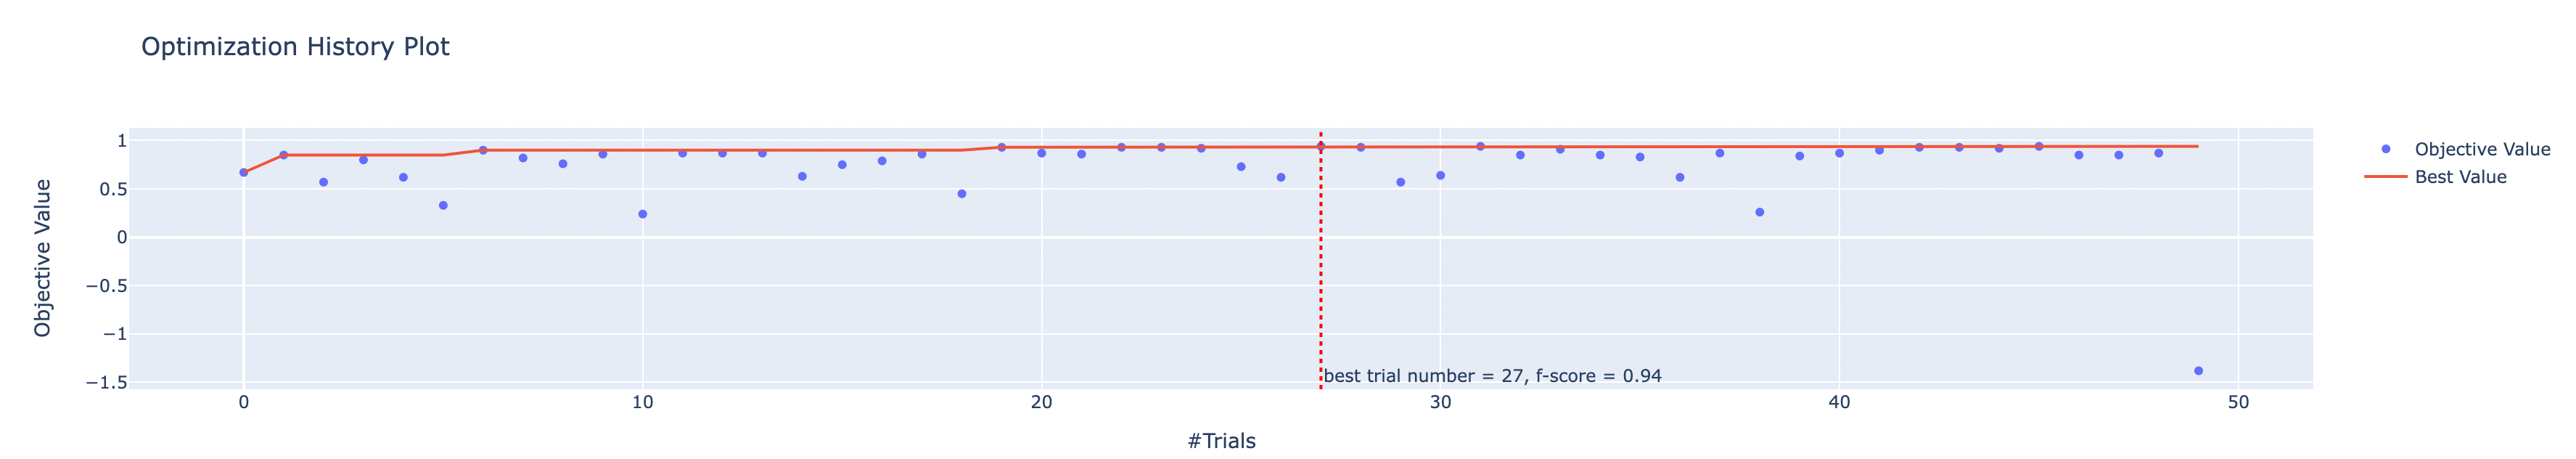

In [40]:
best_trial = study_prophet.best_trial.number
best_trial_val = np.round(study_prophet.best_trial.values[0], 2)
study_fig = optuna.visualization.plot_optimization_history(study_prophet)
study_fig.add_vline(x=best_trial, line_dash="dot", line_color='red', annotation_text=f"best trial number = {best_trial}, f-score = {best_trial_val}", annotation_position="bottom right")
study_fig
Image(filename='./images/ch19_opt.png', width=1800)

In [23]:
# optimal result and corresponding params:
prophet_best_params=study_prophet.best_trial

# top r-squared value:
prophet_best_score = np.round(prophet_best_params.value, 3)

print(f"R-squared: {prophet_best_score}")
print("best params for Prophet: {}".format(prophet_best_params.params))

R-squared: 0.94
best params for XGB: {'holidays_opt': False, 'weekly_seasonality': 40, 'yearly_seasonality': 20, 'add_monthly': True, 'add_reserve': True, 'changepoint_prior_scale': 4.2, 'holidays_prior_scale': 3.6500000000000004, 'month_fourier': 15}


&nbsp;

### Best paramaters:
* Above, we can see that the best model returns a pretty respectable r-squared value of 0.94. 
* the model is not using holidays('holidays_opt': False), 
* it is using a 'weekly_seasonality' value of 40 (explained below), 
* it is using monthly seasonality with a fourier param of 15 (in addition to 30.5 periods)
* 'changepoint_prior_scale' euquals 4.2
* and it is incorporating the external regressor (i.e. it is employing the number of reservations into the model)

For reference:

Yearly seasonality, weekly seasonality and daily seasonality parameters are the # of fourier terms that will be used to make-up the 'wave-length' patterns in our data set. They do not represent the number of periods.

&nbsp;

### Build final model and compare:

In [25]:
# initialize, add external regressor, and fit:
mf = Prophet(weekly_seasonality=40,
            yearly_seasonality=20,
            changepoint_prior_scale=4.2,
            holidays_prior_scale=3.65)

# seasonality and additional regressors:
mf.add_seasonality(name='monthly', period=30.5, fourier_order=15)
mf.add_regressor('reserve_visitors')
mf.fit(train_x)

# define forecast df:
pred_steps = len(test)
futuref = mf.make_future_dataframe(periods=pred_steps)
futuref['ds'] = pd.to_datetime(futuref['ds']).dt.date

# add date and reservations to the forecast df:
futuref = futuref.merge(X_reservations, left_on = 'ds', right_on = 'visit_date', how = 'left')[['ds', 'reserve_visitors']].fillna(0)

# forecast:
forecastf = mf.predict(futurex)

# score
final_score = np.round(r2_score(list(test['y']), list(forecastf.loc[450:,'yhat'])), 2)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1118.89   0.000786972       113.736           1           1      107   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1119.57   0.000279023        9.3208           1           1      217   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1119.63    0.00014835       13.0936      0.8728      0.8728      321   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1119.78   0.000559732        20.698           1           1      425   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1119.87   0.000116567       6.84087           1           1      533   
    Iter      log prob        ||dx||      ||grad||       alpha  

0.94

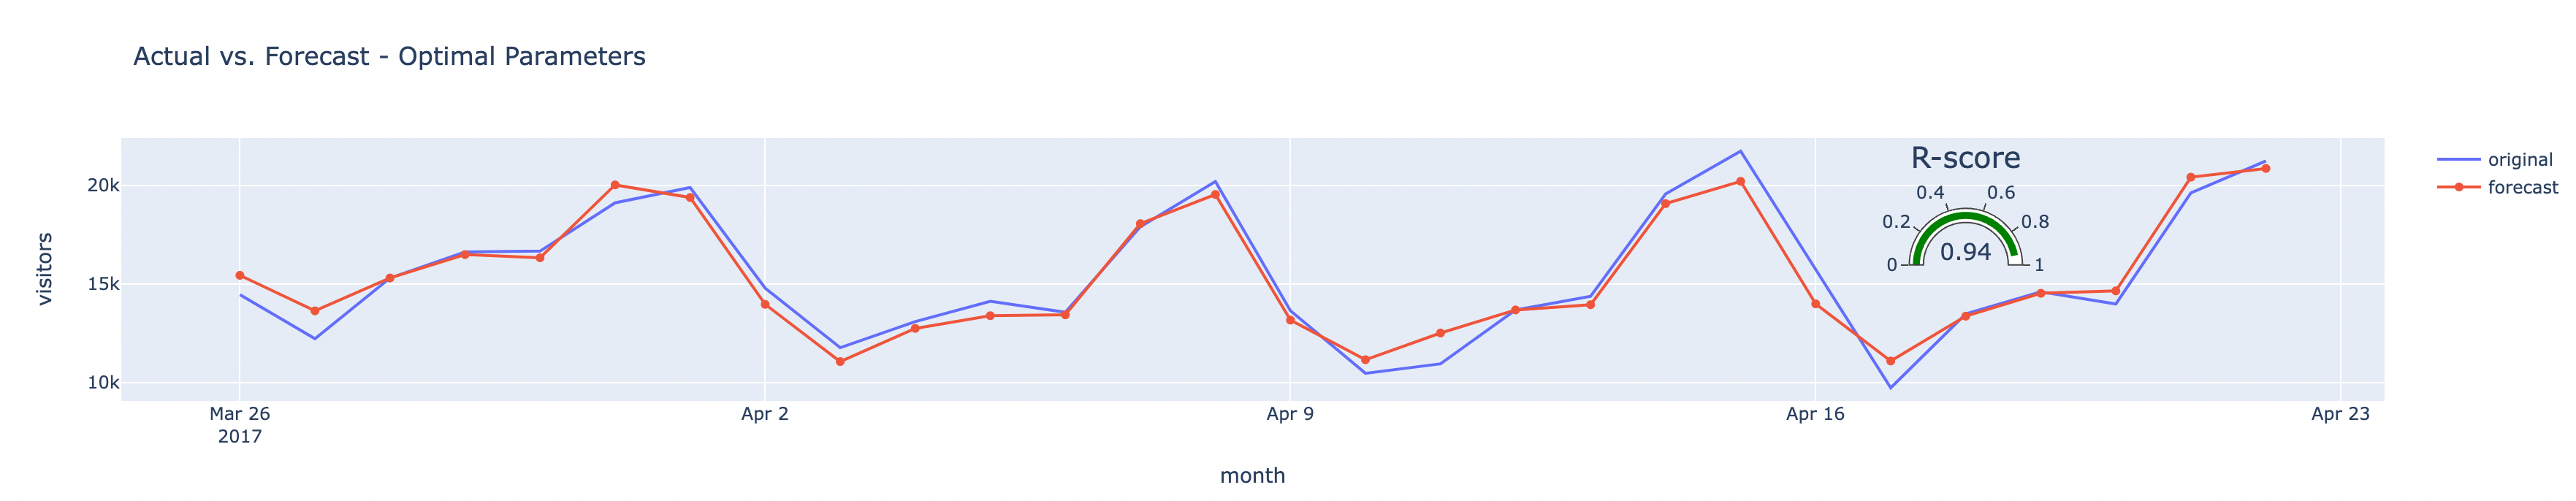

In [41]:
fig = go.Figure()

# actual:
fig.add_trace(go.Scatter(x=test['ds'], y=test['y'], mode='lines', name='original'))
# predicted:
fig.add_trace(go.Scatter(x=test['ds'], y=forecastf.loc[450:,'yhat'], mode='lines+markers', name='forecast'))
# r-score:
fig.add_trace(go.Indicator(
    mode = "gauge+number",
    value = final_score,
    title = {'text': "R-score"},
    domain = {'x': [0.79, 0.84], 'y': [0.5, 0.75]},
    gauge = {'axis': {'range': [0, 1]}},
))

fig.update_layout(
    title="Actual vs. Forecast - Optimal Parameters",
    xaxis_title="month",
    yaxis_title="visitors")
Image(filename='./images/ch19_final.png', width=1800)

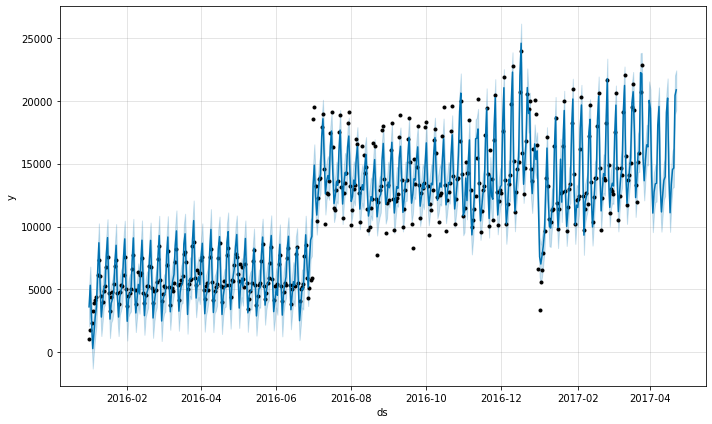

In [32]:
mf.plot(forecastf);

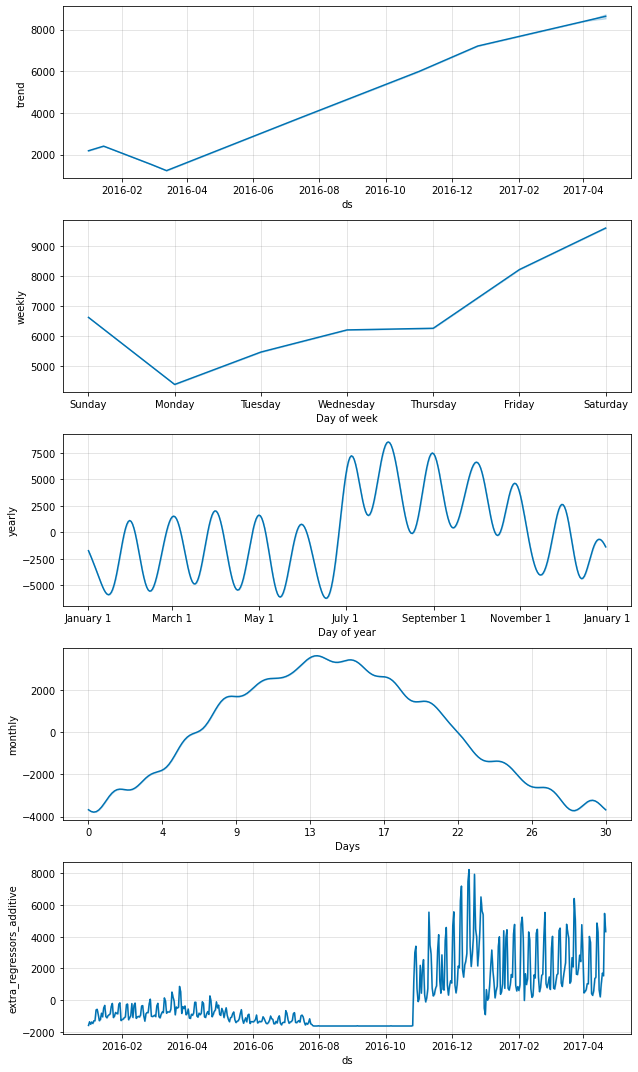

In [31]:
mf.plot_components(forecastf);